In [1]:
import os
import numpy as np
import pandas as pd
from trackml.dataset import load_event
from trackml.randomize import shuffle_hits
from trackml.score import score_event
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib.pyplot as plt
from hough import *
from conformalMap import *

%matplotlib inline

### Load event data

In [194]:
event_prefix = 'event000001000'
hits, cells, particles, truth = load_event(os.path.join('train_100_events', event_prefix))
averageNumberHits = particles['nhits'].mean()
#hits.head()
#cells.head()
particles.head()
#truth.head()
print(averageNumberHits)

8.42412134061812


### Select volumes

In [3]:
cond = (hits['volume_id'] == 8) | (hits['volume_id'] == 13) | (hits['volume_id'] == 17)
selected_indices = hits.index[cond].tolist()
selected_hits = hits.iloc[selected_indices]
selected_truth = truth.iloc[selected_indices]

### Plot some ground truth tracks, 17 of them

8188
1


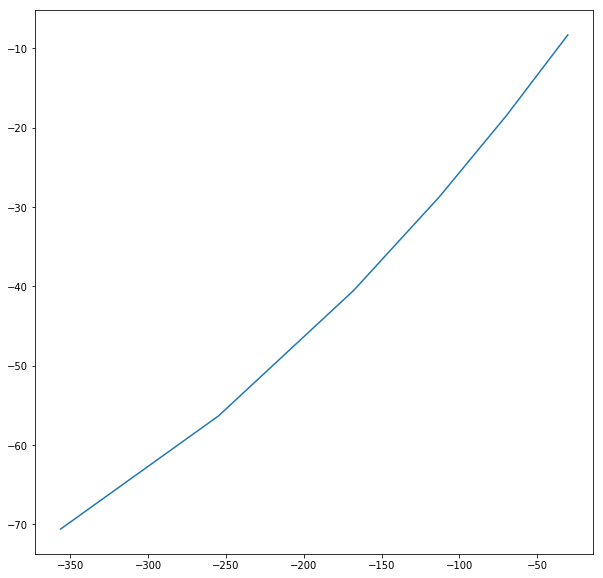

In [383]:
plt.figure(figsize=(10,10))
ax = plt.axes()
# Separate the tracks
tracks = selected_truth.particle_id.unique()[1::100]
#tracks = [tracks[i] for i in range(30, 31)]
tracks = [tracks[35]]
print(len(selected_truth.particle_id.unique()))
print(len(tracks))
for track in tracks:
    # A value of 0 means that the hit did not originate 
    # from a reconstructible particle, but e.g. from detector noise.
    if track == 0:
        continue
    t = selected_truth[selected_truth.particle_id == track]
    ax.plot(t.tx, t.ty)

plt.show()

### Perform conformal mapping

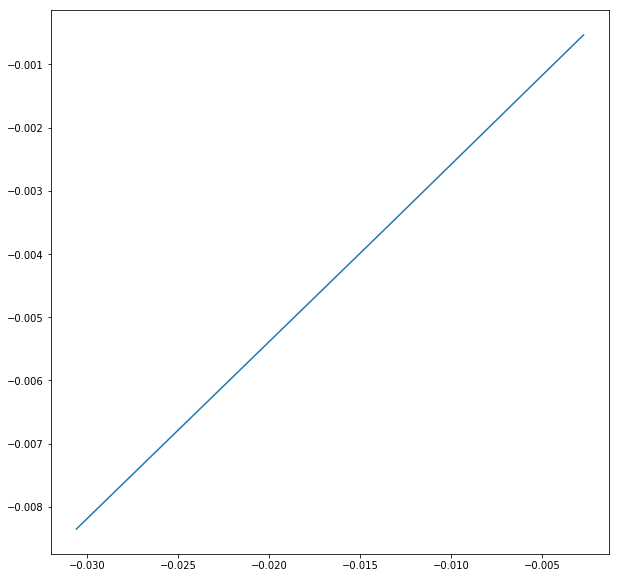

In [384]:
plt.figure(figsize=(10,10))
ax = plt.axes()
for track in tracks:
    # A value of 0 means that the hit did not originate 
    # from a reconstructible particle, but e.g. from detector noise.
    if track == 0:
        continue
    t = selected_truth[selected_truth.particle_id == track]
    conformal_tx, conformal_ty = conformalMapping(zip(t.tx, t.ty))
    ax.plot(conformal_tx, conformal_ty)

plt.show()

### Volumes we see

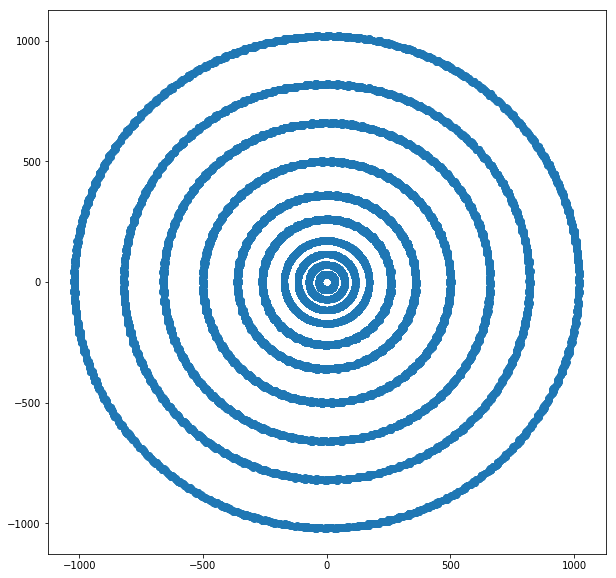

In [385]:
plt.figure(figsize=(10,10))
ax = plt.axes()
ax.plot(selected_hits.x, selected_hits.y, 'o')
plt.show()

### Conformal mapping on all volumes

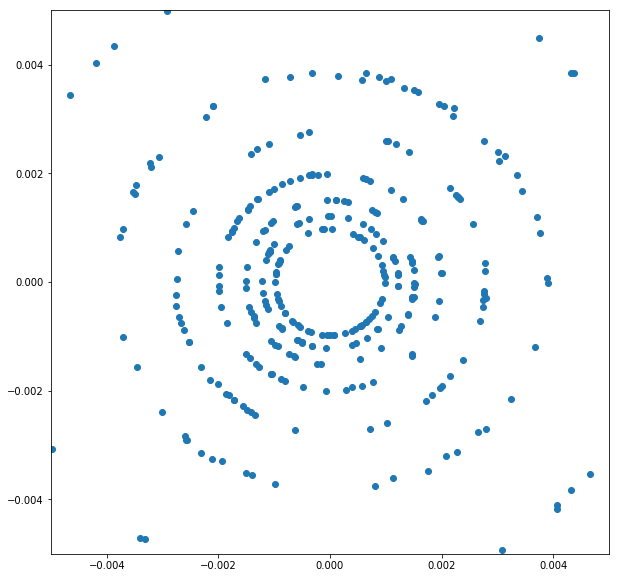

In [386]:
plt.figure(figsize=(10,10))
ax = plt.axes()

# dont show all
N = len(selected_hits.x)
booleanArr = np.random.rand(N) < 0.01
conformal_x, conformal_y = conformalMapping(zip(selected_hits.x, selected_hits.y))
conformal_x = np.array(conformal_x)
conformal_y = np.array(conformal_y)
ax.plot(conformal_x[booleanArr], conformal_y[booleanArr], 'o')
res = 0.005
ax.set_xlim(-res, res)
ax.set_ylim(-res, res)
plt.show()

### Hough transform for some truth tracks

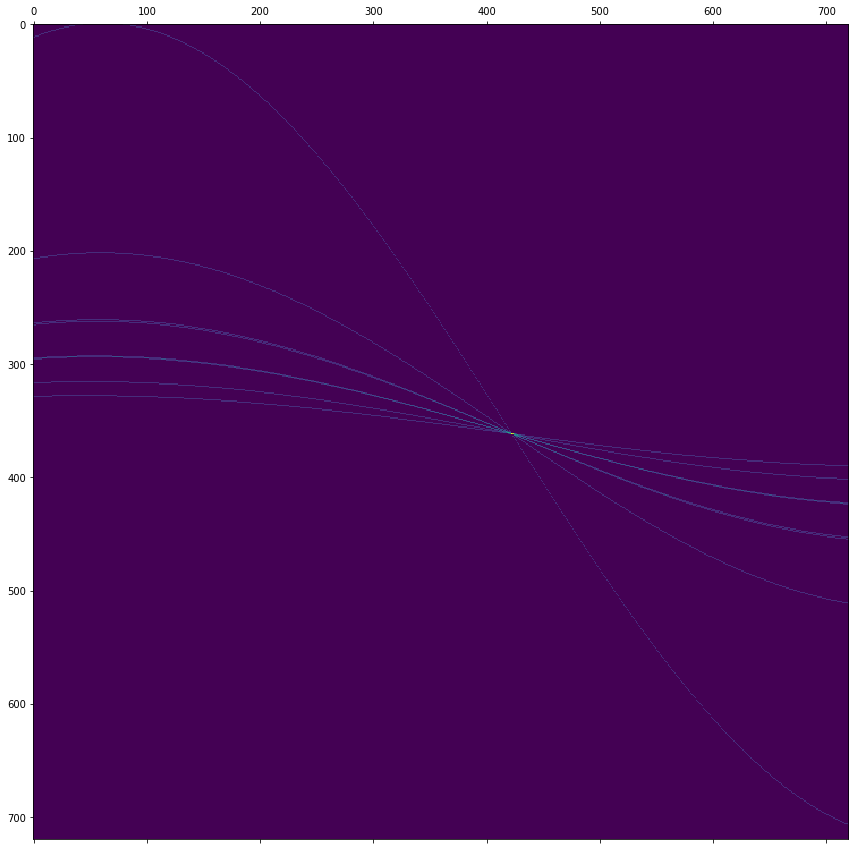

In [387]:
# Chose every 500th track
#tracks = selected_truth.particle_id.unique()[1::200]
allTrackPoints = np.empty((0, 2))
for track in tracks:
    # A value of 0 means that the hit did not originate 
    # from a reconstructible particle, but e.g. from detector noise.
    if track == 0:
        continue
    t = selected_truth[selected_truth.particle_id == track]
    ctx, cty = conformalMapping(zip(t.tx, t.ty))
    ct = np.dstack([ctx, cty])[0]
    
    allTrackPoints = np.append(allTrackPoints, ct, axis=0)

# we know tracks originate from origin so add one point there
#allTrackPoints = np.vstack([allTrackPoints, np.array([0, 0])])

firstQuad = np.empty((0, 2))
secondQuad = np.empty((0, 2))
thirdQuad = np.empty((0, 2))
fourthQuad = np.empty((0, 2))
for p in allTrackPoints:
    if p[0] > 0 and p[1] > 0:
        firstQuad = np.vstack([firstQuad, p])
    elif p[0] < 0 and p[1] > 0:
        secondQuad = np.vstack([secondQuad, p])
    elif p[0] < 0 and p[1] < 0:
        thirdQuad = np.vstack([thirdQuad, p])
    elif p[0] > 0 and p[1] < 0:
        fourthQuad = np.vstack([fourthQuad, p])

# Assign values to hough space
from math import pi
maxRho = max([np.linalg.norm(p) for p in allTrackPoints])
minRho = -maxRho
# -pi / 2 -> pi / 2 works best
minTheta = 0
maxTheta = pi - 10**-10
# Best values seem to be 250 and 360 respectively 
nrBinsRho = 720 #360
nrBinsTheta = 720 #360

accumulator, maxRho, minRho, nrBinsRho, nrBinsTheta, thetas = createHoughSpace(allTrackPoints, minRho, maxRho, minTheta, maxTheta, nrBinsRho, nrBinsTheta)


plt.figure(figsize=(15, 15))
ax = plt.axes()
ax.matshow(accumulator)
plt.show()

### Visualize the Hough space

In [388]:
#visualizeHoughSpace3D(accumulator, minRho, maxRho, minTheta, maxTheta, nrBinsRho, nrBinsTheta)
threshhold = int(averageNumberHits) - 1 # Super dependent on this
maxPoints = findMaxValues(accumulator, nrBinsRho, nrBinsTheta, threshhold)
print(maxPoints)
#print(maxPoints)
maxIndex = np.unravel_index(np.argmax(accumulator), accumulator.shape)
print(maxIndex)
print(accumulator[maxIndex[0], maxIndex[1]])
#print(nMax)

[(362, 422)]
(362, 422)
8.0


In [389]:
maxRhos, maxThetas = extractRhoAndTheta(maxPoints, thetas, minRho, maxRho, nrBinsRho)
maxRhos = maxRhos + 10**-5

### Create lines from the rho and theta values

In [390]:
import math
lim = 2
y_approxes = []
for i in range(len(maxRhos)):
    y_approx = []
    for x_approx in range(-lim,lim):
        if math.sin(maxThetas[i]) != 0:
            y_approx.append((maxRhos[i] - x_approx * math.cos(maxThetas[i])) / math.sin(maxThetas[i]));
    if len(y_approx) > 0:
        y_approxes.append(y_approx)
y_approxes = np.array(y_approxes)

### Draw the lines of rho and theta values to visualize

8


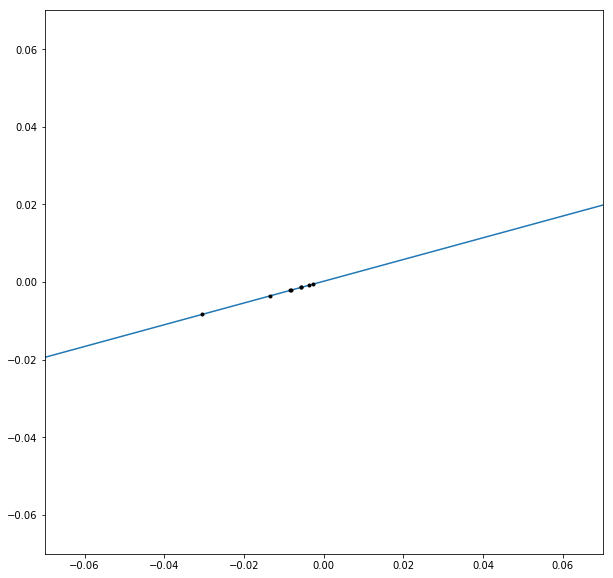

In [391]:
plt.figure(figsize=(10,10))
ax = plt.axes()
# This is the point to focus on
lim = .07
ax.set_ylim(-lim, lim)
ax.set_xlim(-lim, lim)
for y_approx in y_approxes:
    ax.plot(range(-2, 2), y_approx)
print(len(allTrackPoints))
for p in allTrackPoints:
    if p[0] == 0 and p[1] == 0:
        ax.plot(p[0], p[1], '.b')
    else:
        ax.plot(p[0], p[1], '.k')
plt.show()

In [392]:
print(maxRhos.shape)
print(maxRhos)
print(maxThetas.shape)
print(maxThetas)

(1,)
[0.00018627]
(1,)
[1.84388331]


### Extract circle values

In [393]:
# lines here is just [[rho, theta], ...]
lines = np.dstack((maxRhos, maxThetas))[0]
circles = inverseConformalMapping(lines)
#print(circles)
print(len(circles))

1


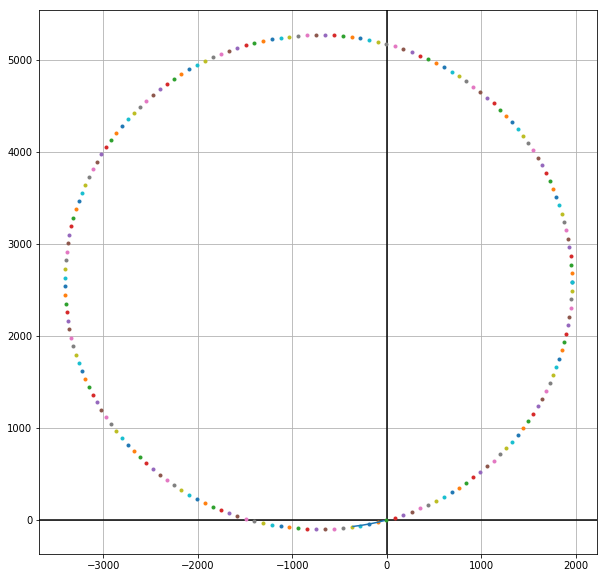

In [394]:
plt.figure(figsize=(10,10))
ax = plt.axes()
ax.grid(True, which='both')
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')
zoom = 2000
#ax.set_xlim(-zoom, zoom)
#ax.set_ylim(-zoom, zoom)
for circle in circles:
    if circle[0] == -1 and circle[1] == -1 and circle[2] == -1:
        continue
    yCircle = []
    for t in np.linspace(0, pi * 2, 180):
        yCircle.append(circleFunction(circle[0], circle[1], circle[2], t))

    for circlePoint in yCircle:
        ax.plot(circlePoint[0], circlePoint[1], '.')
        
        

# Separate the tracks
#tracks = selected_truth.particle_id.unique()[1::500]
for track in tracks:
    # A value of 0 means that the hit did not originate 
    # from a reconstructible particle, but e.g. from detector noise.
    if track == 0:
        continue
    t = selected_truth[selected_truth.particle_id == track]
    ax.plot(t.tx, t.ty)

        
plt.savefig("reconstruct.png")
plt.show()

### Calculate momentum of found particle tracks

In [395]:
momentum = np.empty((0))
for circle in circles:
    R = circle[2] # radius of circle
    if R < 0:
        R *= -1
    q = 1 # charge of particle
    B = 2 # magnetic field strength
    momentum = np.append(momentum, 0.3 * B * R * 0.001)

In [396]:
print(momentum)

[1.6105323]


In [381]:
for track in tracks:
    # A value of 0 means that the hit did not originate 
    # from a reconstructible particle, but e.g. from detector noise.
    if track == 0:
        continue
    t = selected_truth[selected_truth.particle_id == track]
    # Seems that whichever index I pick it has the same momentum (I belive it makes sense)
    px = t['tpx'].iloc[0]
    py = t['tpy'].iloc[0]
    pz = t['tpz'].iloc[0]
    print(np.linalg.norm(np.array([px, py])))
    
    

1.1963308
